In [1]:
!apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  adwaita-icon-theme alsa-topology-conf alsa-ucm-conf at-spi2-common
  at-spi2-core ca-certificates-java cm-super-minimal dbus dbus-bin dbus-daemon
  dbus-session-bus-common dbus-system-bus-common dbus-user-session
  dconf-gsettings-backend dconf-service default-jre default-jre-headless
  dmsetup dvisvgm fontconfig fonts-dejavu-extra fonts-droid-fallback
  fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre fonts-texgyre-math
  fonts-urw-base35 ghostscript gir1.2-girepository-2.0 gir1.2-glib-2.0
  gsettings-desktop-schemas gtk-update-icon-cache hicolor-icon-theme
  humanity-icon-theme java-common libapache-pom-java libapparmor1 libargon2-1
  libasound2-data libasound2t64 libatk-bridge2.0-0t64 libatk-wrapper-java
  libatk-wrapper-java-jni libatk1.0-0t64 libatspi2.0-0t64 libauthen-sasl-perl
  libavahi-client3 libavahi-common-data libavah

In [6]:
!apt install python3-pandas

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libaec0 libblosc1 libblosc2-2t64 libhdf5-103-1t64 liblzo2-2 libsnappy1v5
  libsz2 python-babel-localedata python-odf-doc python-odf-tools
  python-tables-data python3-babel python3-bottleneck python3-cpuinfo
  python3-defusedxml python3-et-xmlfile python3-jinja2 python3-markupsafe
  python3-numexpr python3-odf python3-openpyxl python3-pandas-lib
  python3-tables python3-tables-lib
Suggested packages:
  python-bottleneck-doc python-jinja2-doc python-openpyxl-doc
  python-pandas-doc python3-statsmodels python3-netcdf4 python-tables-doc
  vitables
Recommended packages:
  python3-numba
The following NEW packages will be installed:
  libaec0 libblosc1 libblosc2-2t64 libhdf5-103-1t64 liblzo2-2 libsnappy1v5
  libsz2 python-babel-localedata python-odf-doc python-odf-tools
  python-tables-data python3-babel python3-bottleneck python3-cpuinfo
  p

In [10]:
#run_times = ['23-03-2025_19:52:39', '23-03-2025_20:59:45']

run_times = ['23-03-2025_18:09:20', '23-03-2025_19:45:50']

## Drawing confidence band

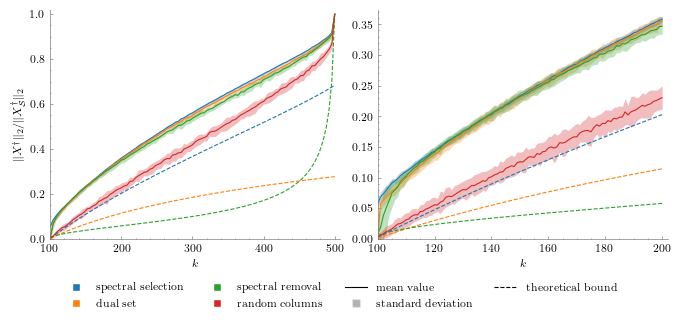

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# LaTeX configuration and style setup
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 8,
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "lines.linewidth": 0.8,
    "axes.linewidth": 0.5,
    "axes.edgecolor": 'gray'
})

# Document dimensions
cm = 1/2.54  # centimeters in inches
text_width = 17 * cm

# Plot parameters
FIG_SIZE = (text_width, 0.5 * text_width * 0.8)  # Golden ratio
SHOW_LEGEND = True  #Set this to True when needed

def create_subplot(position, run_time, ax):
    path = '../out/run_' + run_time + '/'
    with open(path + 'run_info.json', 'r') as file:
        run_info = json.load(file)

    max_y = 0
    for idx, algorithm in enumerate(run_info['algorithms']):
        algorithm_underscored = algorithm.replace(' ', '_')

        points = pd.read_csv(path + algorithm_underscored + '_points.csv')
        bound = pd.read_csv(path + algorithm_underscored + '_bound.csv')

        k_values = np.sort(points['k'].unique())
        sqrt_values = np.sqrt(points['value'])

        mean_values = sqrt_values.groupby(points['k']).mean()
        std_values = sqrt_values.groupby(points['k']).std()
        ci = 1.96 * std_values

        color = plt.cm.tab10(idx)

        #ax.scatter(points['k'], np.sqrt(points['value']), color=color, alpha=0.1, s=1)

        ####

        # Main plot with confidence interval
        ax.set_xlim(k_values[0], k_values[0] + (k_values[-1] - k_values[0]) * (51.0 / 50))
        max_y = max(max_y, np.max(sqrt_values))
        ax.set_ylim(0, max_y * (51.0 / 50))
        ax.plot(k_values, mean_values, color=color)
        ax.fill_between(k_values, mean_values - ci, mean_values + ci,
                        color=color, alpha=0.3, linewidth=0)


        # Theoretical bound
        if not (bound['value'] == 0).all():
            ax.plot(bound['k'], np.sqrt(bound['value']),
                    color=color, linestyle='--')
    # Manage tiks
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=2, width=0.5, color='gray', direction='in')
    ax.tick_params(axis='both', which='minor', length=1, width=0.5, color='gray', direction='in')


    # Axis labels
    ax.set_xlabel(r'$k$')
    if position == 'left':
        ax.set_ylabel(r'$\Vert X^\dag \Vert_2 / \Vert X_\mathcal{S}^\dag \Vert_2$')

    # Grid and borders
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


def create_plot(run_times):
    fig, ax = plt.subplots(figsize=FIG_SIZE, nrows=1, ncols=2, layout='constrained')

    create_subplot('left', run_times[0], ax[0])
    create_subplot('right', run_times[1], ax[1])

    path = '../out/run_' + run_times[0] + '/'
    with open(path + 'run_info.json', 'r') as file:
        run_info = json.load(file)

    # Create custom legend
    if SHOW_LEGEND:
        custom_legend = []
        for algorithm in run_info['algorithms']:
            color = plt.cm.tab10(list(run_info['algorithms']).index(algorithm))
            custom_legend.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=color, markeredgecolor='white', label=algorithm, markersize=6))

        custom_legend.append(plt.Line2D([0], [0], linestyle='-', label='mean value', color='black'))
        custom_legend.append(plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='black', markeredgecolor='white', alpha=0.3, label='standard deviation', markersize=6))
        custom_legend.append(plt.Line2D([0], [0], linestyle='--', label='theoretical bound', color='black'))

        leg = fig.legend(handles=custom_legend, framealpha=0.9,
                       loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, ncols=4)
        #leg.get_frame().set_linewidth(0.5)
        leg.get_frame().set_edgecolor("1")

    plt.savefig('plot.pdf', bbox_inches='tight')
    plt.show()
    plt.close()

create_plot(run_times)

## Russian version

In [53]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.size'] = 16

# Open and read the JSON file
path = '../out/run_' + run_time + '/'
with open(path + 'run_info.json', 'r') as file:
    run_info = json.load(file)

# Create a single figure
plt.figure(figsize=(10, 6))
alg_names = ["новый алгоритм",
             "алгоритм 2 из [1]",
      "алгоритм 3 из [1]",
      "случайные столбцы"]

# Iterate over algorithms and plot confidence intervals
i = 0
for algorithm in run_info['algorithms']:
    algorithm_undersored = algorithm.replace(' ', '_')

    points = pd.read_csv(path + algorithm_undersored + '_points.csv')
    bound = pd.read_csv(path + algorithm_undersored + '_bound.csv')

    # Calculate mean and standard deviation of points for each k
    k_values = points['k'].unique()
    k_values = np.sort(k_values)
    mean_values = np.array([np.sqrt(points[points['k'] == k]['value']).mean() for k in k_values])
    std_values = np.array([np.sqrt(points[points['k'] == k]['value']).std() for k in k_values])
    upper_values = mean_values + 1.96 * std_values
    lower_values = mean_values - 1.96 * std_values

    # Plot confidence interval
    plt.plot(k_values, mean_values)
    plt.plot(k_values, upper_values, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)), alpha = 0.0)
    plt.plot(k_values, lower_values, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)), alpha = 0.0)
    plt.fill_between(k_values, lower_values, upper_values, alpha=0.33, color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)))

    # Check if bound is all zeros
    if not (bound['value'] == 0).all():
        plt.plot(bound['k'], np.sqrt(bound['value']), linestyle='--', color=plt.cm.tab10(list(run_info['algorithms']).index(algorithm)))
    i += 1

# Set title and labels
plt.xlabel('k')
plt.ylabel(r'$\Vert X^\dag \Vert_2 / \Vert X_S^\dag \Vert_2$')
# Create custom legend
custom_legend = []
i = 0
for algorithm in run_info['algorithms']:
    color = plt.cm.tab10(list(run_info['algorithms']).index(algorithm))
    custom_legend.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, label=alg_names[i], markersize=10))
    i+=1
plt.legend(handles=custom_legend, loc='best')

# Save plot
plt.tight_layout()
plt.savefig(path + 'confidence_intervals_plot_ru.svg')
plt.close()